In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cross_validation
import io

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

As there is a difference of one column which is nothing but a target field which is not there in test dataset.

In [4]:
print('Train Shape: ',train.shape)
print('Test  Shape: ',test.shape)

Train Shape:  (1460, 81)
Test  Shape:  (1459, 80)


In [5]:
print("# Numerical Features: ",len(train.select_dtypes(include=[np.number]).columns))
print("# Categorical Features: ",len(train.select_dtypes(exclude=[np.number]).columns))

# Numerical Features:  38
# Categorical Features:  43


#### Dividing data into numerical and categorical features

In [6]:
# All features except of number dtype will considered as categorical features
catfeatures = train.select_dtypes(exclude=[np.number])

# All features of type number
numfeatures = train.select_dtypes(include=[np.number]).copy()

numfeatures.drop(['Id','MSSubClass'],axis=1,inplace=True)
catfeatures['MSSubClass'] = train['MSSubClass']

e:\users\qlikdeveloper8\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [7]:
catfeatures.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition', 'MSSubClass'],
      dtype='object')

## <br>Numerical Features

In [8]:
numfeatures.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

#### Highly correlated features

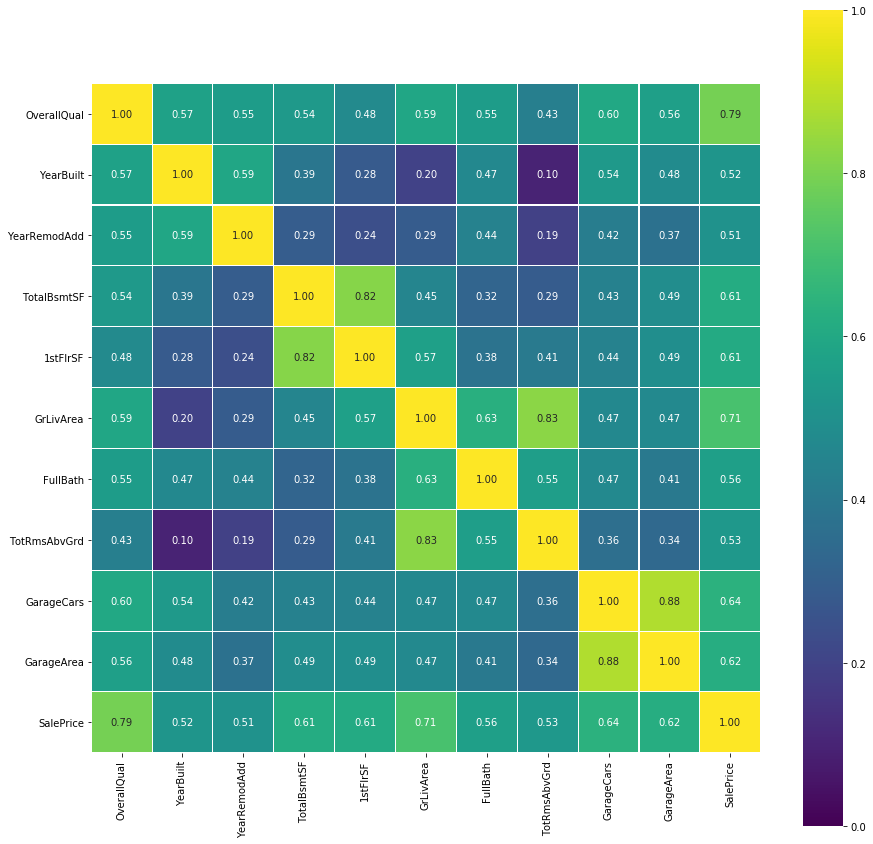

In [9]:
corr = numfeatures.corr()

#Highly Correlated Features
numfeatures_high_corr = corr[corr.index[(corr['SalePrice']>0.50) | (corr['SalePrice']<-0.5)]].loc[
    corr.index[(corr['SalePrice']>0.50) | (corr['SalePrice']<-0.5)]]

# Heatmap 
plt.figure(figsize=(15,15))
sns.heatmap(numfeatures_high_corr,annot=True,fmt='.2f', 
            vmax=1.0, vmin=0.0,cmap='viridis',square=True,annot_kws={"size":10},linewidths=0.1)

highly_corr_features = numfeatures_high_corr.drop('SalePrice').index
del(numfeatures_high_corr)

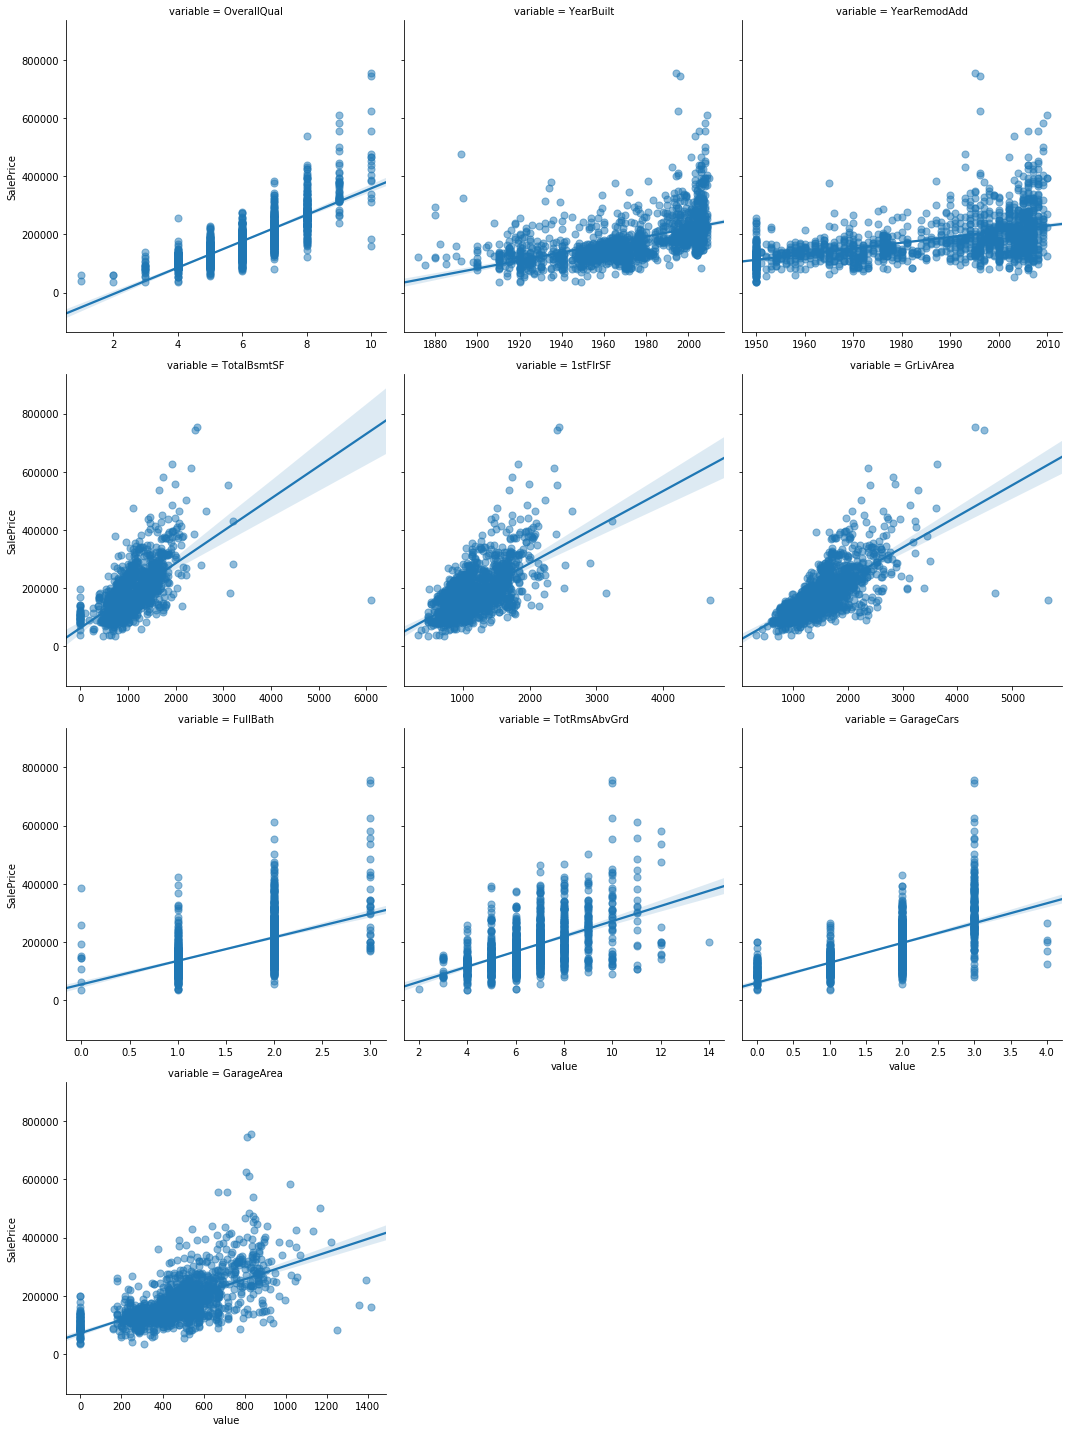

In [10]:
f = pd.melt(numfeatures,
        id_vars=['SalePrice'], 
        value_vars=highly_corr_features)
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=True, size=5)
g = g.map(sns.regplot, "value", "SalePrice", scatter_kws={"alpha":0.5,"s":50})

As we can see in the HeatMap, GarageArea and GarageCars has 0.88 correlation coefficient. Now, wea are going to dig in to do some feature engineering.

Correlation:  (0.8824754142814621, 0.0)


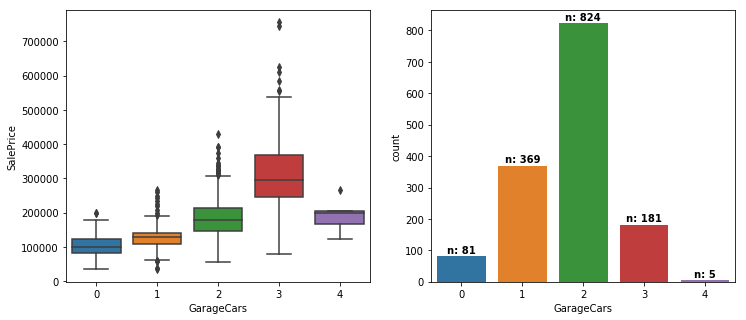

In [11]:
from scipy.stats import pearsonr
print('Correlation: ', pearsonr(numfeatures.GarageCars, numfeatures.GarageArea))
fig, axes = plt.subplots(1,2,figsize=(12,5))
axis = []
for i, ax in enumerate(fig.axes):
    axis.append(ax)
sns.boxplot('GarageCars', 'SalePrice',data=numfeatures, ax=axis[0] )
ax = sns.countplot('GarageCars', data=numfeatures, ax=axis[1])

pos_y = numfeatures['GarageCars'].value_counts().sort_index().values
nobs = ["n: " + str(i) for i in pos_y]
pos_x = numfeatures['GarageCars'].value_counts().sort_index().index.tolist()

for tick, label in zip(range(len(nobs)),nobs):
    ax.text(pos_x[tick], pos_y[tick] + 10.0, label, color='k', weight='bold', fontsize = 10,
            horizontalalignment='center')
plt.show()

In [12]:
# sns.lmplot('YearBuilt','SalePrice',data=df[df.GarageYrBlt.isnull()],fit_reg=True,size=10,palette='copper',
#           scatter_kws={"alpha":0.5, "s":300})

# print(df[df['GarageYrBlt']!=df['YearBuilt']].GarageYrBlt.value_counts(dropna=False).iloc[:3])
# print(df[df.GarageYrBlt.isnull()])
# df[df['GarageYrBlt'].isnull].GarageArea.value_counts()

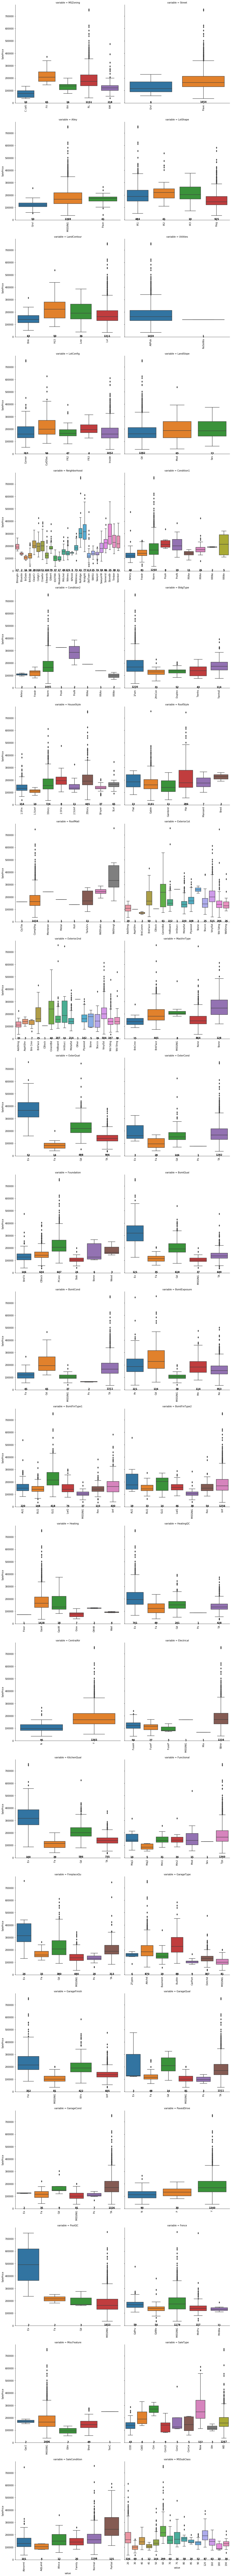

In [29]:
categorical = train.copy()
for i in catfeatures.columns:
    if categorical[i].isnull().any():
        categorical[i].fillna('MISSING', inplace=True)

    
def boxplot(x, y,  **kwargs):
    
    
    df = pd.DataFrame(dict(Value=x, SalePrice=y))
    df.sort_values(by='Value', inplace=True)
    ax = sns.boxplot(x='Value', y='SalePrice',data=df)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    pos_y = df.Value.value_counts().sort_index().values
    text = [str(i) for i in pos_y]
    pos_x = df.Value.unique()
#     print(df.Value.value_counts().sort_index())
    for tick, label in zip(range(len(text)), text):
#         if tick < (len(text)-1):
        ax.text(tick, pos_y[tick], label, weight='bold', fontsize=10, color='k', horizontalalignment='center')
#         ax.text(tick, pos_y[tick]+10000, label, weight='bold', fontsize=10, color='k', horizontalalignment='center')
#     plt.show()
    
f = pd.melt(categorical,
        id_vars=['SalePrice'], 
#         value_vars=['MSZoning']
        value_vars=catfeatures.columns.tolist()
           )

g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=True, size=7)
g = g.map(boxplot, "value", "SalePrice")


In [87]:
train.MSSubClass.value_counts(dropna=False).sort_index().sum()
df = train.copy()
bins = [0, 1900, 1995, 2000, 2005, 2010]
df['YrBuilt_bins']=pd.cut(df['YearBuilt'], bins)

In [30]:
catfeatures.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition', 'MSSubClass'],
      dtype='object')

In [39]:
pd.crosstab(index=train['Foundation'], columns=train['BsmtQual'], values=train['Id'], aggfunc='count')

BsmtQual,Ex,Fa,Gd,TA
Foundation,,,,
BrkTil,1.0,17.0,18.0,109.0
CBlock,2.0,12.0,146.0,465.0
PConc,118.0,5.0,451.0,70.0
Stone,NaN,1.0,NaN,5.0
Wood,NaN,NaN,3.0,NaN


# Building Model

### Spliting Data Set  

In [63]:
from sklearn.model_selection import train_test_split

In [103]:
feats = highly_corr_features.tolist()
feats.append('MSSubClass')

In [165]:
data = train.copy()
categorical.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [167]:
# train['enc_neighborhood']=
# pd.get_dummies(train.Neighborhood, drop_first=True)
final = pd.merge(data,pd.get_dummies(train.Neighborhood, drop_first=True), how='inner', left_index=True, right_index=True)
# train.Neighborhood.value_counts().sort_values(ascending=False)

In [199]:
# feats.append(pd.get_dummies(train.Neighborhood, drop_first=True).columns.tolist())
# feats
feats = feats + pd.get_dummies(train.Neighborhood, drop_first=True).columns.tolist()
feats

['LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'Blueste',
 'BrDale',
 'BrkSide',
 'ClearCr',
 'CollgCr',
 'Crawfor',
 'Edwards',
 'Gilbert',
 'IDOTRR',
 'MeadowV',
 'Mitchel',
 'NAmes',
 'NPkVill',
 'NWAmes',
 'NoRidge',
 'NridgHt',
 'OldTown',
 'SWISU',
 'Sawyer',
 'SawyerW',
 'Somerst',
 'StoneBr',
 'Timber',
 'Veenker']

In [198]:
feats = numfeatures.drop(['SalePrice','GarageYrBlt','LotFrontage','MasVnrArea'], axis=1).columns.tolist()
feats

['LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [201]:
sum(final[feats].isnull().sum().sort_values(ascending=False))

0

In [202]:
y = np.log(final.SalePrice)
x = final[feats]
x_train, x_test, y_train, y_test = train_test_split(x,y,
                                                   random_state = 42,
                                                   test_size = 0.33)

In [203]:
regr = LinearRegression()
model = regr.fit(x_train, y_train)

In [204]:
# feats = test[highly_corr_features].interpolate()

In [205]:
predict = model.predict(x_test)

In [101]:
mean_squared_error(y_test, predict)

0.027123732916997018

In [142]:
mean_squared_error(y_test, predict)

0.022897586376285375

In [206]:
mean_squared_error(y_test, predict)

0.019454409197860754

In [207]:
regr.coef_

array([ 1.26878787e-06,  6.46975550e-02,  4.33739628e-02,  2.26090609e-03,
        1.01869277e-03,  1.50606745e-05,  1.11975486e-05,  8.80500723e-07,
        2.71387232e-05,  3.53904001e-05, -3.78090992e-05,  1.15087303e-04,
        1.12668613e-04,  6.39428456e-02,  2.03114149e-02,  4.23996978e-02,
        4.76132618e-02,  1.31312529e-02, -1.25562433e-01,  2.46243854e-02,
        4.99415286e-02,  7.05656575e-02,  4.22688010e-05,  1.29538274e-04,
       -6.07955568e-05,  2.35410720e-04,  3.56467695e-04,  3.94827339e-04,
       -5.04298242e-04, -1.08004658e-05,  1.41979716e-03, -1.54596121e-03,
       -1.52868992e-01, -1.82669597e-01,  2.39987252e-02,  1.56511253e-01,
        7.36441553e-02,  1.66976402e-01, -3.25067459e-02,  2.23409051e-02,
       -8.50637246e-02, -1.85054290e-01,  2.96756706e-02,  2.10475920e-02,
       -7.07793489e-02, -1.42189382e-02,  1.56203320e-01,  1.73962604e-01,
       -2.38260751e-02,  1.98777209e-02,  6.14614363e-03,  1.17137878e-02,
        1.16733765e-01,  

### Cross Validation 

In [208]:
from sklearn import cross_validation

In [209]:
cv = cross_validation.KFold(len(x), n_folds=10 )

In [210]:
result=[]
for traincv, testcv in cv:
    probs = regr.fit(x.loc[traincv], y.loc[traincv]).predict(x.loc[testcv])
    result.append(mean_squared_error(y.loc[testcv],probs)**0.5)

In [211]:
result.sort()
result

[0.11009284888331164,
 0.11335918052707804,
 0.11719346465455859,
 0.12079837793723443,
 0.13287414411204623,
 0.13475616552251518,
 0.13967899389740485,
 0.15255248641381344,
 0.1731663417436146,
 0.22998079189129542]